# Fine Tunning com lista de produtos

Este notebook realiza o fine-tuning de um modelo pre-treinado, a partir de um dataset que contem uma lista de produtos existentes no site da amazon.
O resultado esperado é que após o treinamento, o modelo seja capaz de responder corretamente as perguntas realizadas sobre os determinados produtos pertecentes ao dataset treinado.


Monta o drive para acesso aos arquivos.

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Instalação das dependencias

In [63]:
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers==0.0.27 "trl<0.9.0" peft accelerate bitsandbytes # Downgrade xformers to 0.0.27
!pip install -q transformers datasets triton torch torchvision xformers

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-cxy6iiud/unsloth_52817a2dfd524fcfbe586074d6393228
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-cxy6iiud/unsloth_52817a2dfd524fcfbe586074d6393228
  Resolved https://github.com/unslothai/unsloth.git to commit 8c155a2c07fc6521c869e44fb5f43b93fc0b81ff
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached xformers-0.0.27-cp312-cp312-manylinux2014_x86_64.whl.metadata (1.0 kB)
Using cached xformers-0.0.27-cp312-cp312-manylinux2014_x86_64.whl (164.2 MB)
  Attempting uninstall: xformers
    Found existing installation: xformers 0.0.32.post2
    Uninstalling xformers-0.0.32.post2:
      Successfully uninstalled xformers-0.0.32.post2


In [64]:
# note: we must use at least L4 GPU
from unsloth import FastLanguageModel, is_bfloat16_supported
import torch
import json
from datasets import load_dataset
from trl import SFTTrainer
from transformers import TrainingArguments, TextStreamer



Definição de variáveis e do caminho do arquivos do dataset.

In [76]:
DATA_PATH = "/content/drive/MyDrive/tc3/trn.json"
OUTPUT_PATH_DATASET = "/content/drive/MyDrive/tc3/trn_output.json"
max_seq_length = 2048
dtype = None
load_in_4bit = True
fourbit_models = [
    "unsloth/mistral-7b-v0.3-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/llama-3-8b-bnb-4bit",
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "unsloth/llama-3-70b-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct",
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",
]


Carregamento do Modelo pre-treinado

In [77]:
# Load do modelo pre-treinado
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    device_map="auto"
)

==((====))==  Unsloth 2025.10.1: Fast Llama patching. Transformers: 4.56.2.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


# Teste antes do treinamento

Realizamos um teste de pergunta sobre o produto antes de realizarmos o Fine-Tuning. Com isso podemos comparar o resultado final do tunning.

In [67]:
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    prompt.format(
        "Describe the product [input]", # instruction
        "'Nice for Mice'", # input
        "", # output—leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")


text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Describe the product [input]

### Input:
'Nice for Mice'

### Response:
A mouse pad that is nice to look at and nice to touch.

<|end_of_text|>


In [68]:
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    prompt.format(
        "Describe the product [input]", # instruction
        "'On Happiness, U.S. Edition'", # input
        "", # output—leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")


text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Describe the product [input]

### Input:
'On Happiness, U.S. Edition'

### Response:
The product is a book titled 'On Happiness, U.S. Edition'. It is a book about happiness and how to achieve it. The book is written by a famous author and has been published in several languages. It is available in both paperback and e-book formats. The book is available for purchase on Amazon, Barnes & Noble, and other bookstores.<|end_of_text|>


# Inicio do Fine-tuning do modelo

Função que ira criar a formatação dos dados do dataset para treinar o modelo em como ele devera responder as perguntas;

In [69]:
import json
from typing import Iterable, Dict

def iter_jsonl(path: str) -> Iterable[Dict]:
    with open(path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue
            try:
                yield json.loads(line)
            except json.JSONDecodeError as e:
                print(f"Skipping bad JSON on line {i}: {e}")

def format_dataset(DATA_PATH: str, OUTPUT_PATH_DATASET: str) -> None:
    formatted_count = 0
    skipped_empty = 0
    with open(OUTPUT_PATH_DATASET, 'w', encoding='utf-8') as out:
        for item in iter_jsonl(DATA_PATH):
            title = (item.get('title') or '').strip()
            content = (item.get('content') or '').strip()
            # skip if either is empty
            if not title or not content:
                skipped_empty += 1
                continue

            formatted_item = {
                "instruction": "Describe the product [input]",
                "input_text": title,
                "response": f"The '{title}' is {content}"
            }
            out.write(json.dumps(formatted_item, ensure_ascii=False) + "\n")
            formatted_count += 1

    print(f"Wrote {formatted_count} records to {OUTPUT_PATH_DATASET}. Skipped {skipped_empty} empty rows.")


format_dataset(DATA_PATH, OUTPUT_PATH_DATASET)

Wrote 1390403 records to /content/drive/MyDrive/tc3/trn_output.json. Skipped 858216 empty rows.


Definição do prompt do dataset e realização de um map a partir do arquivo formadado;

In [70]:
from transformers import AutoTokenizer
from datasets import load_dataset


# Definindo o template do prompt com base na estrutura dos seus dados
product_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

# Inicialize o tokenizer (ajuste o nome do modelo conforme necessário)
tokenizer = AutoTokenizer.from_pretrained(model)

# Define o token de fim de sequência (EOS)
EOS_TOKEN = tokenizer.eos_token

def formatting_prompts_func(examples):
    """Formata os exemplos de entrada com base no template do prompt."""
    # Extrai os campos relevantes dos exemplos
    instructions = examples["instruction"]
    inputs = examples["input_text"]
    outputs = examples["response"]
    texts = []

    # Formata cada exemplo com o template definido
    for instruction, input_text, output in zip(instructions, inputs, outputs):
        # Usa o template para criar o prompt completo
        text = product_prompt.format(instruction, input_text, output) + EOS_TOKEN
        texts.append(text)

    # Retorna o texto formatado que será usado no treinamento
    return {"text": texts}


# Carrega o dataset usando o caminho especificado e seleciona o split de treinamento
dataset = load_dataset("json", data_files=OUTPUT_PATH_DATASET, split="train")

# Aplica a formatação dos prompts aos dados carregados
dataset = dataset.map(formatting_prompts_func, batched=True)

# Visualize alguns exemplos formatados (opcional)
print(dataset[0])


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1390403 [00:00<?, ? examples/s]

{'instruction': 'Describe the product [input]', 'input_text': 'Girls Ballet Tutu Neon Pink', 'response': "The 'Girls Ballet Tutu Neon Pink' is High quality 3 layer ballet tutu. 12 inches in length", 'text': "Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nDescribe the product [input]\n\n### Input:\nGirls Ballet Tutu Neon Pink\n\n### Response:\nThe 'Girls Ballet Tutu Neon Pink' is High quality 3 layer ballet tutu. 12 inches in length</s>"}


Preparação dos parametros de treinamento (LoRas)

In [78]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",

    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Objeto de Callback customizado para gerarmos o grafico com o resultado do treinamento

In [72]:
from transformers import TrainerCallback

class CustomCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])

callback = CustomCallback()

Instaciamento do objeto do modelo de treinamento

In [79]:
# Train the model
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    callbacks=[callback],
    args = TrainingArguments(
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 4,
        warmup_ratio = 0.2,
        learning_rate = 3e-5,
        max_steps = 60,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        num_train_epochs=4,                   # no of samples per step * this would be total steps
        save_strategy="steps",
        save_steps=10,
    ),
)

Map (num_proc=2):   0%|          | 0/1390403 [00:00<?, ? examples/s]

# Treinamento do modelo carregado

In [80]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,390,403 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 4 x 1) = 32
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)


Step,Training Loss
1,2.679900
2,2.470500
3,2.542600
4,2.802900
5,2.681300
6,2.562500
7,2.563300
8,2.520400
9,2.707000
10,2.711700


Criação do grafico com os dados de treinamento.

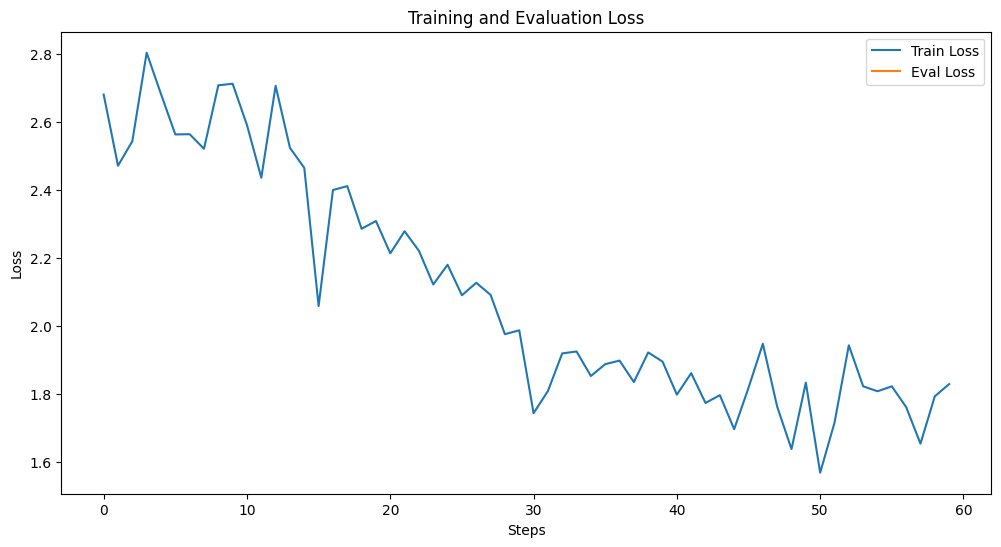

In [81]:
import matplotlib.pyplot as plt

# Plot training loss for train & eval sets
plt.figure(figsize=(12, 6))
plt.plot(callback.train_losses, label='Train Loss')
plt.plot(callback.eval_losses, label='Eval Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()

# Teste do modelo treinado

Aqui realizamos as perguntas para verificar a diferença entre o antes e o depois do modelo treinado.

Verificamos aqui que as respostas do modelo ja fazem maior sentido em ralação a base de dados.

In [82]:
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    prompt.format(
        "Describe the product [input]", # instruction
        "'On Happiness, U.S. Edition'", # input
        "", # output—leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")


text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Describe the product [input]

### Input:
'On Happiness, U.S. Edition'

### Response:
The 'On Happiness, U.S. Edition' is On Happiness: A Reader, a collection of essays and articles on happiness and well-being, edited by Daniel Nettle, a Reader in Evolution and Behaviour at Newcastle University. It is an edited collection of writings on happiness and well-being, by authors such as William James, John Stuart Mill, David Hume, Aristotle, Bertrand Russell, Thomas Jefferson, and others. It is published by Penguin Books, 2005, and is a part of their 'Penguin on Happiness' series.</s><|end_of_text|>


In [84]:
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    prompt.format(
        "Describe the product [input]", # instruction
        "'The book of revelation'", # input
        "", # output—leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")


text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Describe the product [input]

### Input:
'The book of revelation'

### Response:
'The Book of Revelation is a New Testament apocalyptic book composed in Koine Greek. It occupies a central place in Christian eschatology and is considered to be one of the most powerful religious symbols in the history of Christianity.'<|end_of_text|>


# Salvamento do modelo em arquivo


In [ ]:
model.save_pretrained("/content/drive/MyDrive/tc3/lora_model") # Local saving
tokenizer.save_pretrained("/content/drive/MyDrive/tc3/lora_model")